Reference
    
https://keras.io/examples/timeseries/timeseries_anomaly_detection/

# Setup

In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

from loadData import DataLoader


# Load data

In [2]:
path = '../data-sets/KDD-Cup/data/'

loader = DataLoader(path)
loader.loadData()

data_df_list = loader.getDataInDfList()

..........................................................................................................................................................................................................................................................

In [3]:
name, data_df = data_df_list[33]

df_train = data_df[data_df['label']=='train']['values'].to_frame()
df_test = data_df[data_df['label']=='test']['values'].to_frame()

print(name)
print('df_train.shape =', df_train.shape)
print('df_test.shape =', df_test.shape)

034_UCR_Anomaly_1500.txt
df_train.shape = (1500, 1)
df_test.shape = (6154, 1)


# Visualization

## Plot of training data (without anomaly)

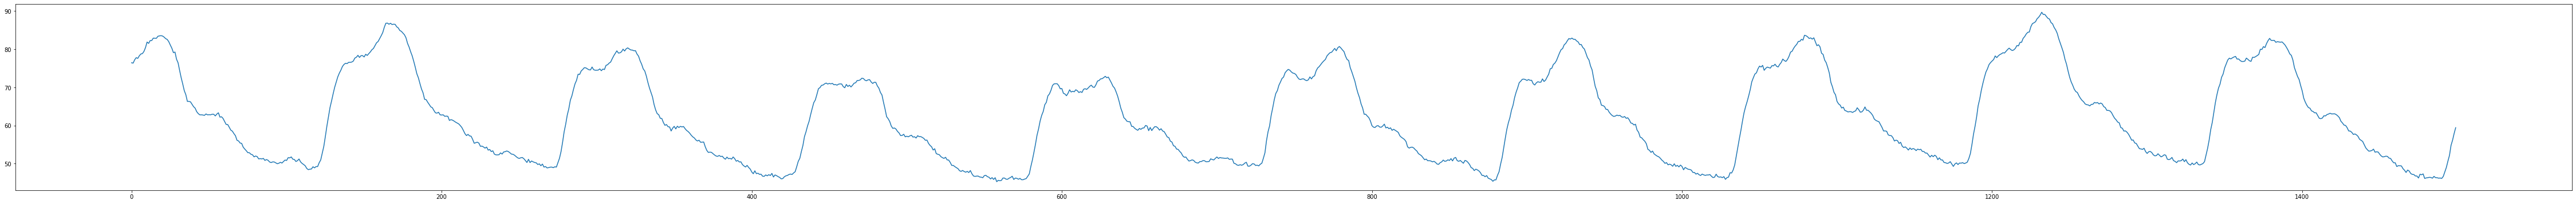

In [4]:
N, M = 80, 6
fig, ax = plt.subplots(figsize=(N, M))
df_train.plot(legend=False, ax=ax)
plt.show()

## Plot of testing data (with anomaly)

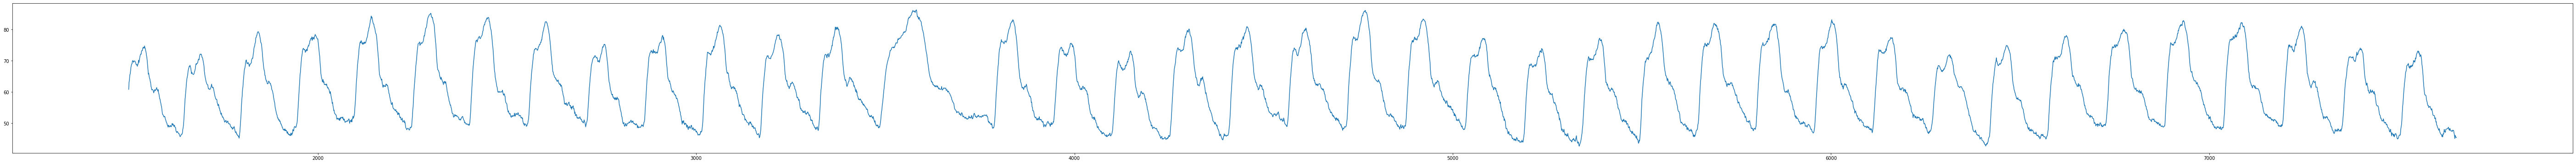

In [5]:
N, M = 100, 6
fig, ax = plt.subplots(figsize=(N, M))
df_test.plot(legend=False, ax=ax)
plt.show()

# Prepare training data

## Normalization

In [6]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_train.mean()
training_std = df_train.std()
df_training_value = (df_train - training_mean) / training_std

print("Number of training samples:", len(df_training_value))

display(df_train)

display(df_training_value)

display(df_train.describe())

df_training_value.describe()

Number of training samples: 1500


values
0     76.458008
1     76.362195
2     77.233139
3     77.797305
4     77.612248
...         ...
1495  52.184675
1496  54.806667
1497  56.179042
1498  57.921033
1499  59.442607

[1500 rows x 1 columns]

values
0     1.215527
1     1.207374
2     1.281481
3     1.329485
4     1.313739
...        ...
1495 -0.849837
1496 -0.626737
1497 -0.509965
1498 -0.361743
1499 -0.232276

[1500 rows x 1 columns]

values
count  1500.000000
mean     62.172443
std      11.752570
min      45.275126
25%      51.324798
50%      59.914537
75%      72.048791
max      89.698638

values
count  1.500000e+03
mean  -1.136868e-16
std    1.000000e+00
min   -1.437755e+00
25%   -9.230019e-01
50%   -1.921202e-01
75%    8.403565e-01
max    2.342143e+00

## Discretize the Time series data by sliding window

In [7]:
# Generated training sequences for use in the model.
def create_sequences(values, time_steps=100):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)

In [8]:
TIME_STEPS = 100 #288
x_train = create_sequences(df_training_value.values, TIME_STEPS)
print("Training input shape: ", x_train.shape)
x_train

Training input shape:  (1401, 100, 1)


array([[[ 1.21552695],
        [ 1.20737443],
        [ 1.28148112],
        ...,
        [-1.02169586],
        [-0.98667135],
        [-0.95483627]],

       [[ 1.20737443],
        [ 1.28148112],
        [ 1.32948475],
        ...,
        [-0.98667135],
        [-0.95483627],
        [-0.96356423]],

       [[ 1.28148112],
        [ 1.32948475],
        [ 1.31373866],
        ...,
        [-0.95483627],
        [-0.96356423],
        [-0.90093938]],

       ...,

       [[ 0.84235562],
        [ 0.70792468],
        [ 0.58819444],
        ...,
        [-0.84983693],
        [-0.62673747],
        [-0.50996514]],

       [[ 0.70792468],
        [ 0.58819444],
        [ 0.4252551 ],
        ...,
        [-0.62673747],
        [-0.50996514],
        [-0.361743  ]],

       [[ 0.58819444],
        [ 0.4252551 ],
        [ 0.33747285],
        ...,
        [-0.50996514],
        [-0.361743  ],
        [-0.23227565]]])

In [9]:
x_train.shape

(1401, 100, 1)

## [no need] Pad zeros in training data

``` python
a = np.arange(12)
display(a)

a = a.reshape((3, 4, 1))
display(a)

data1=np.pad(a, ((0,0), (0,2), (0, 0)), 'constant')
display(data1.shape)

data1
```

In [10]:
# x_train_padded_zero = np.pad(x_train, ((0,0), (0,0), (0, 0)), 'constant')
# x_train_padded_zero.shape

# Build & Train model

In [11]:
def buildTrainSaveAutoencoder(train_df: pd.DataFrame, model_name: str='', folder: str='models/autoencoder'):
    model = keras.Sequential(
        [
            layers.Input(shape=(train_df.shape[1], train_df.shape[2])),
            layers.Conv1D(filters=16, kernel_size=4, padding="same", strides=2, activation="relu"),
            layers.Dropout(rate=0.2),
            layers.Conv1D(filters=8, kernel_size=4, padding="same", strides=2, activation="relu"),
            layers.Conv1DTranspose(filters=8, kernel_size=4, padding="same", strides=2, activation="relu"),
            layers.Dropout(rate=0.2),
            layers.Conv1DTranspose(filters=16, kernel_size=4, padding="same", strides=2, activation="relu"),
            layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
        ]
    )
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
    model.summary()

    if not os.path.exists(folder):
        os.makedirs(folder)
    model.save(folder+'/'+model_name+'.h5')
    
    return model

## Build a model

In [12]:
model = buildTrainSaveAutoencoder(x_train, 'model1')

2021-12-02 23:29:38.059564: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 50, 16)            80        
_________________________________________________________________
dropout (Dropout)            (None, 50, 16)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 25, 8)             520       
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 50, 8)             264       
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 8)             0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 100, 16)           528       
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 100, 1)            1

In [13]:
# model = keras.Sequential(
#     [
#         layers.Input(shape=(x_train_padded_zero.shape[1], x_train_padded_zero.shape[2])),
#         layers.Conv1D(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
#         layers.Dropout(rate=0.2),
#         layers.Conv1D(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
#         layers.Conv1DTranspose(filters=16, kernel_size=7, padding="same", strides=2, activation="relu"),
#         layers.Dropout(rate=0.2),
#         layers.Conv1DTranspose(filters=32, kernel_size=7, padding="same", strides=2, activation="relu"),
#         layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
#     ]
# )
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
# model.summary()


In [14]:
# model = keras.Sequential(
#     [
#         layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
#         layers.Conv1D(filters=16, kernel_size=4, padding="same", strides=2, activation="relu"),
#         layers.Dropout(rate=0.2),
#         layers.Conv1D(filters=8, kernel_size=4, padding="same", strides=2, activation="relu"),
#         layers.Conv1DTranspose(filters=8, kernel_size=4, padding="same", strides=2, activation="relu"),
#         layers.Dropout(rate=0.2),
#         layers.Conv1DTranspose(filters=16, kernel_size=4, padding="same", strides=2, activation="relu"),
#         layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
#     ]
# )
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
# model.summary()


## Train model

In [15]:
history = model.fit(
    x_train, #x_train_padded_zero,
    x_train, #x_train_padded_zero,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

2021-12-02 23:29:38.551929: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50
40/40 [==============================] - 2s 16ms/step - loss: 0.7165 - val_loss: 0.2466
Epoch 2/50
40/40 [==============================] - 0s 9ms/step - loss: 0.1693 - val_loss: 0.0451
Epoch 3/50
40/40 [==============================] - 0s 9ms/step - loss: 0.0646 - val_loss: 0.0374
Epoch 4/50
40/40 [==============================] - 0s 9ms/step - loss: 0.0496 - val_loss: 0.0396
Epoch 5/50
40/40 [==============================] - 0s 9ms/step - loss: 0.0423 - val_loss: 0.0377
Epoch 6/50
40/40 [==============================] - 0s 9ms/step - loss: 0.0370 - val_loss: 0.0333
Epoch 7/50
40/40 [==============================] - 0s 9ms/step - loss: 0.0326 - val_loss: 0.0407
Epoch 8/50
40/40 [==============================] - 0s 10ms/step - loss: 0.0290 - val_loss: 0.0459
Epoch 9/50
40/40 [==============================] - 0s 10ms/step - loss: 0.0263 - val_loss: 0.0403
Epoch 10/50
40/40 [==============================] - 0s 9ms/step - loss: 0.0241 - val_loss: 0.0440
Epoch 11/50
40/4

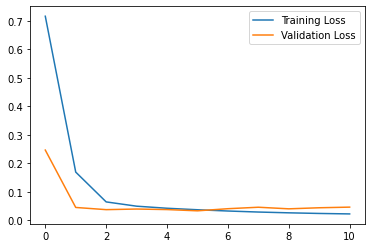

In [16]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

# Detecting anomalies

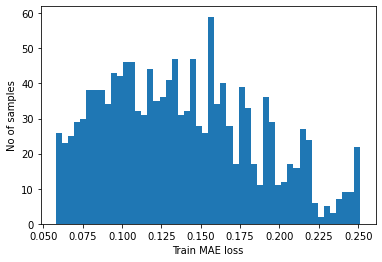

Reconstruction error threshold:  0.25144868880702426


In [17]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

## Compare recontruction

### Test with training data

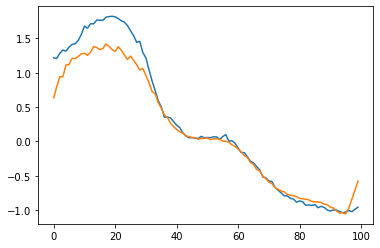

In [18]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

# Test with testing data

##  Prepare test data and predict

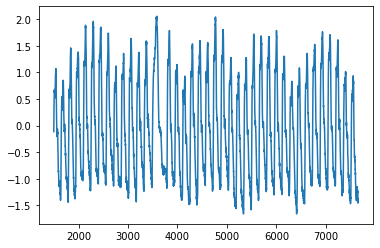

Test input shape:  (6055, 100, 1)
Padded zeros, Test input shape:  (6055, 100, 1)


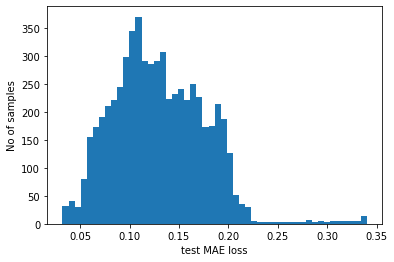

Number of anomaly samples:  73
Indices of anomaly samples:  (array([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
       2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033,
       2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044,
       2045, 2046, 2047, 2048, 2049, 2050, 2051]),)


In [19]:
df_test_value = (df_test - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Padding zeros to meet autoencoder input-dimension 
# x_test = np.pad(x_test, ((0,0), (0,0), (0, 0)), 'constant')
print("Padded zeros, Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

In [20]:
np.where(anomalies)

(array([1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
        1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
        2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
        2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022,
        2023, 2024, 2025, 2026, 2027, 2028, 2029, 2030, 2031, 2032, 2033,
        2034, 2035, 2036, 2037, 2038, 2039, 2040, 2041, 2042, 2043, 2044,
        2045, 2046, 2047, 2048, 2049, 2050, 2051]),)

# Plot anomalies

In [21]:
# # data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
# anomalous_data_indices = []
# for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
#     print(data_idx - TIME_STEPS + 1, data_idx)
#     if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
#         anomalous_data_indices.append(data_idx)

# anomalous_data_indices

values
3479  49.071669
3480  49.431160
3481  49.136521
3482  48.497406
3483  48.472655
...         ...
3547  78.642030
3548  79.059179
3549  79.018478
3550  79.371433
3551  79.123587

[73 rows x 1 columns]

034_UCR_Anomaly_1500.txt


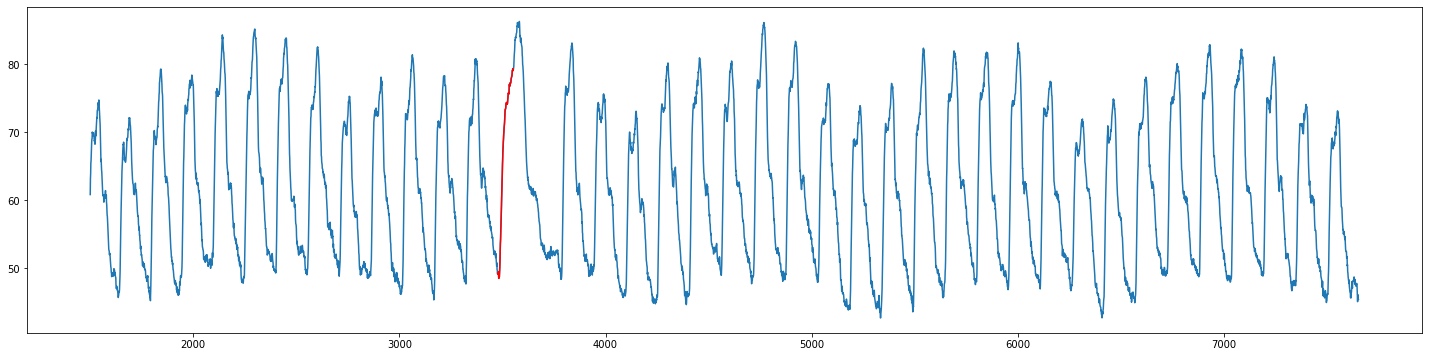

In [22]:
# df_subset = df_test.iloc[anomalous_data_indices]
df_subset = df_test.iloc[np.where(anomalies)]

display(df_subset)

print(name)

N, M = 25, 6
fig, ax = plt.subplots(figsize=(N, M))
df_test.plot(legend=False, ax=ax)
df_subset.plot(legend=False, ax=ax, color="r")
plt.show()

In [27]:
display(df_train)
display(df_train.describe())

display(df_training_value)
display(df_training_value.describe())


values
0     76.458008
1     76.362195
2     77.233139
3     77.797305
4     77.612248
...         ...
1495  52.184675
1496  54.806667
1497  56.179042
1498  57.921033
1499  59.442607

[1500 rows x 1 columns]

values
count  1500.000000
mean     62.172443
std      11.752570
min      45.275126
25%      51.324798
50%      59.914537
75%      72.048791
max      89.698638

values
0     1.215527
1     1.207374
2     1.281481
3     1.329485
4     1.313739
...        ...
1495 -0.849837
1496 -0.626737
1497 -0.509965
1498 -0.361743
1499 -0.232276

[1500 rows x 1 columns]

values
count  1.500000e+03
mean  -1.136868e-16
std    1.000000e+00
min   -1.437755e+00
25%   -9.230019e-01
50%   -1.921202e-01
75%    8.403565e-01
max    2.342143e+00

In [28]:
display(df_test)
display(df_test.describe())

display(df_test_value)
display(df_test_value.describe())


values
1500  60.817419
1501  63.126916
1502  63.901588
1503  65.463496
1504  65.775867
...         ...
7649  45.042070
7650  46.081865
7651  45.737770
7652  45.362732
7653  45.376655

[6154 rows x 1 columns]

values
count  6154.000000
mean     61.470834
std      11.077429
min      42.640477
25%      51.298406
50%      60.678205
75%      71.479281
max      86.318560

values
1500 -0.115296
1501  0.081214
1502  0.147129
1503  0.280028
1504  0.306607
...        ...
7649 -1.457585
7650 -1.369111
7651 -1.398390
7652 -1.430301
7653 -1.429116

[6154 rows x 1 columns]

values
count  6154.000000
mean     -0.059698
std       0.942554
min      -1.661932
25%      -0.925248
50%      -0.127141
75%       0.791898
max       2.054539